<a href="https://colab.research.google.com/github/plthiyagu/AI-Engineering/blob/master/04-Deep%20Learning/End_to_End_Machine_Learning_Pipeline_using_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%load_ext tensorboard

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium

from folium import plugins

import tensorflow as tf
import tensorflow.keras as keras

print(tf.__version__)

device= "gpu"

if device == "tpu":
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.envrionment['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)
  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.experimental.TPUSttategy(resolver)
else:
  strategy= tf.distribute.MultiWorkerMirroredStrategy()


2.4.0
INFO:tensorflow:Using MirroredStrategy with devices ('/device:CPU:0',)
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:CPU:0',), communication = CommunicationImplementation.AUTO


In [3]:
!wget https://raw.githubusercontent.com/tensorflow/tfx/master/tfx/examples/chicago_taxi_pipeline/data/simple/data.csv

--2021-01-03 05:21:28--  https://raw.githubusercontent.com/tensorflow/tfx/master/tfx/examples/chicago_taxi_pipeline/data/simple/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1922812 (1.8M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1.83M  --.-KB/s    in 0.09s   

2021-01-03 05:21:29 (20.0 MB/s) - ‘data.csv’ saved [1922812/1922812]



In [4]:
df = pd.read_csv('/content/data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15002 entries, 0 to 15001
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   pickup_community_area   15000 non-null  float64
 1   fare                    15002 non-null  float64
 2   trip_start_month        15002 non-null  int64  
 3   trip_start_hour         15002 non-null  int64  
 4   trip_start_day          15002 non-null  int64  
 5   trip_start_timestamp    15002 non-null  int64  
 6   pickup_latitude         15000 non-null  float64
 7   pickup_longitude        15000 non-null  float64
 8   dropoff_latitude        14519 non-null  float64
 9   dropoff_longitude       14519 non-null  float64
 10  trip_miles              15002 non-null  float64
 11  pickup_census_tract     1 non-null      float64
 12  dropoff_census_tract    10761 non-null  float64
 13  payment_type            15002 non-null  object 
 14  company                 9862 non-null 

In [5]:
df.head()

,pickup_community_area,fare,trip_start_month,trip_start_hour,trip_start_day,trip_start_timestamp,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_miles,pickup_census_tract,dropoff_census_tract,payment_type,company,trip_seconds,dropoff_community_area,tips
0,NaN,12.45,5,19,6,1400269500,NaN,NaN,NaN,NaN,0.0,NaN,NaN,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,0.0,NaN,0.0
1,NaN,0.00,3,19,5,1362683700,NaN,NaN,NaN,NaN,0.0,NaN,NaN,Unknown,Chicago Elite Cab Corp.,300.0,NaN,0.0
2,60.0,27.05,10,2,3,1380593700,41.836150,-87.648788,NaN,NaN,12.6,NaN,NaN,Cash,Taxi Affiliation Services,1380.0,NaN,0.0
3,10.0,5.85,10,1,2,1382319000,41.985015,-87.804532,NaN,NaN,0.0,NaN,NaN,Cash,Taxi Affiliation Services,180.0,NaN,0.0
4,14.0,16.65,5,7,5,1369897200,41.968069,-87.721559,NaN,NaN,0.0,NaN,NaN,Cash,Dispatch Taxi Affiliation,1080.0,NaN,0.0


In [6]:
##Get unique count for each column
df.nunique()

pickup_community_area        62
fare                        423
trip_start_month             12
trip_start_hour              24
trip_start_day                7
trip_start_timestamp      13789
pickup_latitude             236
pickup_longitude            236
dropoff_latitude            291
dropoff_longitude           291
trip_miles                  530
pickup_census_tract           1
dropoff_census_tract        229
payment_type                  7
company                      61
trip_seconds                110
dropoff_community_area       69
tips                        462
dtype: int64

In [7]:
df.describe()

,pickup_community_area,fare,trip_start_month,trip_start_hour,trip_start_day,trip_start_timestamp,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_miles,pickup_census_tract,dropoff_census_tract,trip_seconds,dropoff_community_area,tips
count,15000.000000,15002.000000,15002.000000,15002.000000,15002.000000,1.500200e+04,15000.000000,15000.000000,14519.000000,14519.000000,15002.000000,1.000000e+00,1.076100e+04,14996.000000,14495.000000,15002.000000
mean,22.250267,11.768216,6.585655,13.632316,4.186642,1.408495e+09,41.903046,-87.657551,41.902672,-87.654113,2.872820,1.703108e+10,1.703135e+10,777.627501,20.967782,1.076674
std,19.414828,11.538850,3.390997,6.620927,2.015694,2.916043e+07,0.037751,0.067846,0.038478,0.056616,15.276007,NaN,3.312243e+05,977.538769,17.641056,2.158340
min,1.000000,0.000000,1.000000,0.000000,1.000000,1.357000e+09,41.694879,-87.913625,41.663671,-87.913625,0.000000,1.703108e+10,1.703101e+10,0.000000,1.000000,0.000000
25%,8.000000,5.850000,4.000000,9.000000,2.000000,1.384622e+09,41.880994,-87.655998,41.880994,-87.656804,0.000000,1.703108e+10,1.703108e+10,360.000000,8.000000,0.000000
50%,8.000000,7.850000,7.000000,15.000000,4.000000,1.407260e+09,41.892508,-87.633308,41.893216,-87.634156,1.000000,1.703108e+10,1.703124e+10,540.000000,12.000000,0.000000
75%,32.000000,12.450000,10.000000,19.000000,6.000000,1.431339e+09,41.921877,-87.626211,41.922686,-87.626215,2.500000,1.703108e+10,1.703183e+10,960.000000,32.000000,2.000000
max,77.000000,700.070000,12.000000,23.000000,7.000000,1.483116e+09,42.009623,-87.572782,42.021224,-87.540936,1710.000000,1.703108e+10,1.703198e+10,72120.000000,77.000000,47.000000


In [8]:
##Drop useless columns
df = df.drop(['trip_start_timestamp','trip_miles','pickup_census_tract',
              'dropoff_census_tract','trip_seconds','payment_type','tips', 
              'company','dropoff_community_area','pickup_community_area'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15002 entries, 0 to 15001
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare               15002 non-null  float64
 1   trip_start_month   15002 non-null  int64  
 2   trip_start_hour    15002 non-null  int64  
 3   trip_start_day     15002 non-null  int64  
 4   pickup_latitude    15000 non-null  float64
 5   pickup_longitude   15000 non-null  float64
 6   dropoff_latitude   14519 non-null  float64
 7   dropoff_longitude  14519 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 937.8 KB


In [9]:
#Drop NA rows
df.dropna()

#Drop rows where FARE > 200( only 1 row found )
df =df.drop(df[df['fare']>200].index)

df['trip_start_month'] = df['trip_start_month'].astype('str')
df['trip_start_hour'] = df['trip_start_hour'].astype('str')
df['trip_start_day'] = df['trip_start_day'].astype('str')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15001 entries, 0 to 15001
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare               15001 non-null  float64
 1   trip_start_month   15001 non-null  object 
 2   trip_start_hour    15001 non-null  object 
 3   trip_start_day     15001 non-null  object 
 4   pickup_latitude    14999 non-null  float64
 5   pickup_longitude   14999 non-null  float64
 6   dropoff_latitude   14518 non-null  float64
 7   dropoff_longitude  14518 non-null  float64
dtypes: float64(5), object(3)
memory usage: 1.0+ MB


In [10]:
##Train test split ( Original DF )
np.random.seed(seed=2)
msk = np.random.rand(len(df)) < 0.85
traindf = df[msk]
evaldf = df[~msk]

print(len(traindf))
print(len(evaldf))

traindf.to_csv("train.csv", index=False, header=False)
evaldf.to_csv("eval.csv", index=False, header=False)

12746
2255


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


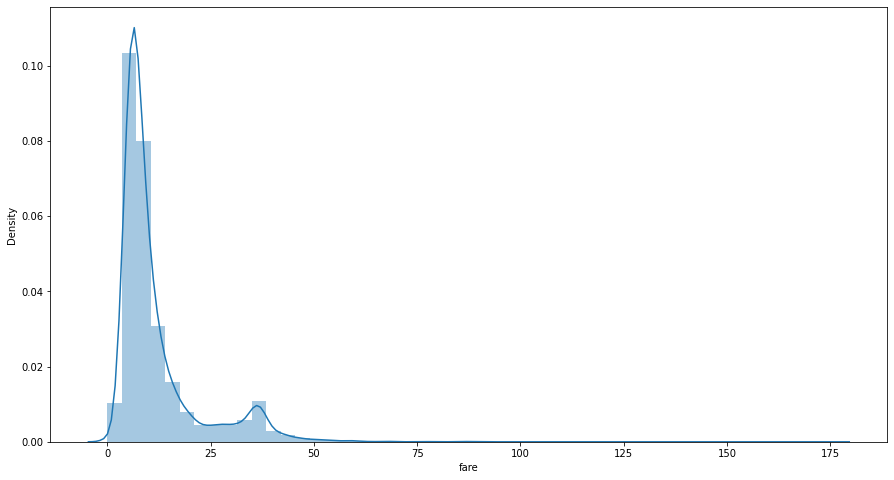

In [11]:
##Distribution of Fare
plt.figure(figsize=(15, 8))
sns.distplot(traindf['fare'])

In [12]:
traindf.isnull().any()

fare                 False
trip_start_month     False
trip_start_hour      False
trip_start_day       False
pickup_latitude       True
pickup_longitude      True
dropoff_latitude      True
dropoff_longitude     True
dtype: bool

In [13]:
traindf.dropna()

,fare,trip_start_month,trip_start_hour,trip_start_day,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
28,12.25,10,1,1,41.952823,-87.653244,41.920452,-87.679955
29,3.85,3,15,6,41.899670,-87.669838,41.920452,-87.679955
30,6.05,8,23,5,41.906026,-87.675312,41.920452,-87.679955
31,7.25,10,21,7,41.906651,-87.665338,41.920452,-87.679955
32,7.85,11,11,2,41.871016,-87.631407,41.849247,-87.624135
...,...,...,...,...,...,...,...,...
14995,6.85,1,17,5,41.904935,-87.649907,41.904935,-87.649907
14996,3.45,10,20,4,41.904935,-87.649907,41.904935,-87.649907
14997,3.25,5,11,5,41.904935,-87.649907,41.904935,-87.649907
14999,4.25,12,13,3,41.904935,-87.649907,41.904935,-87.649907


In [14]:
traindf.shape

(12746, 8)

In [15]:
traindf = traindf.apply (pd.to_numeric, errors='coerce')
traindf = traindf.dropna()

In [16]:
traindf.shape

(12331, 8)

In [17]:
##Plot locations with heatmap intensity as per the FARE
m = folium.Map()
sw = traindf[['pickup_latitude', 'pickup_longitude']].min().values.tolist()
ne = traindf[['pickup_latitude', 'pickup_longitude']].max().values.tolist()
m.add_child(plugins.HeatMap(zip(traindf['pickup_latitude'], traindf['pickup_longitude'], traindf['fare']), radius = 10))
m.fit_bounds([sw, ne])
m

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

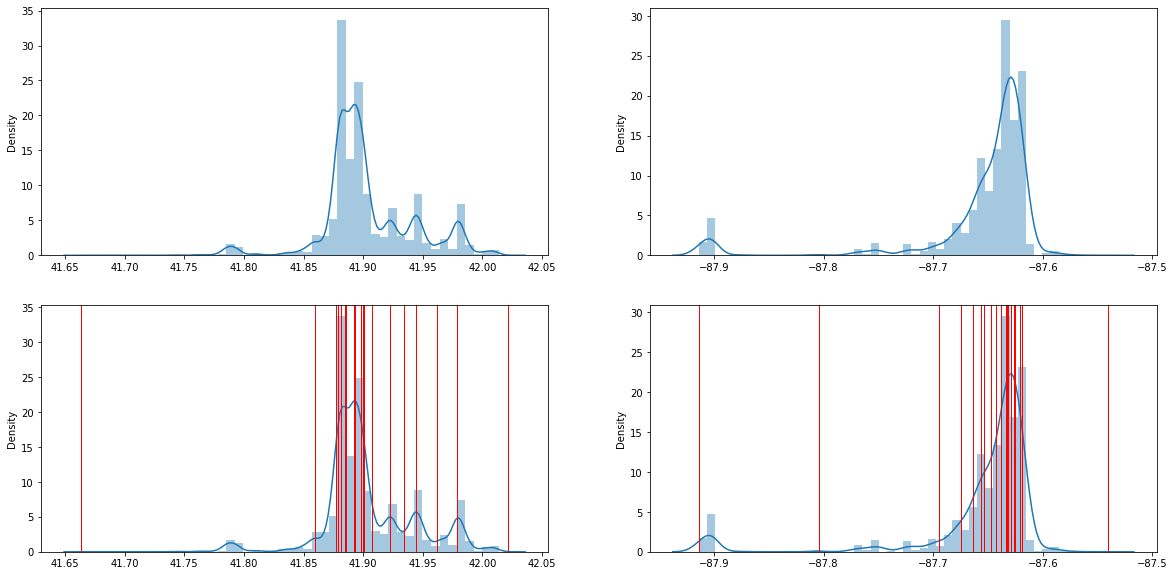

In [18]:
##Quantile Bucketization of latitude and longitude
# bins_lat = np.linspace(np.min([np.min(df['dropoff_latitude']),np.min(df['pickup_latitude'])]),
#             np.max([np.max(df['dropoff_latitude']),np.max(df['pickup_latitude'])]),
#             20)
bins_lat = pd.qcut(list(df['dropoff_latitude'].values) + list(df['pickup_latitude'].values), q=20, duplicates='drop', retbins=True)[1]

# bins_lon = np.linspace(np.min([np.min(df['dropoff_longitude']),np.min(df['pickup_longitude'])]),
#             np.max([np.max(df['dropoff_longitude']),np.max(df['pickup_longitude'])]),
#             20)
bins_lon = pd.qcut(list(df['dropoff_longitude'].values) + list(df['pickup_longitude'].values), q=20, duplicates='drop', retbins=True)[1]

#Plot all latitude values with bins
f, axes = plt.subplots(2, 2, figsize=(20, 10), sharex=False)
sns.distplot(list(df['dropoff_latitude'].values) + list(df['pickup_latitude'].values), ax=axes[0, 0])
sns.distplot(list(df['dropoff_longitude'].values) + list(df['pickup_longitude'].values), ax=axes[0, 1])

#Plot bins
sns.distplot(list(df['dropoff_latitude'].values) + list(df['pickup_latitude'].values), ax=axes[1, 0])
sns.distplot(list(df['dropoff_longitude'].values) + list(df['pickup_longitude'].values), ax=axes[1, 1])
for b_ in bins_lat:
  axes[1][0].axvline(b_, color='red', linewidth=1 )
for b_ in bins_lon:
  axes[1][1].axvline(b_, color='red', linewidth=1 )

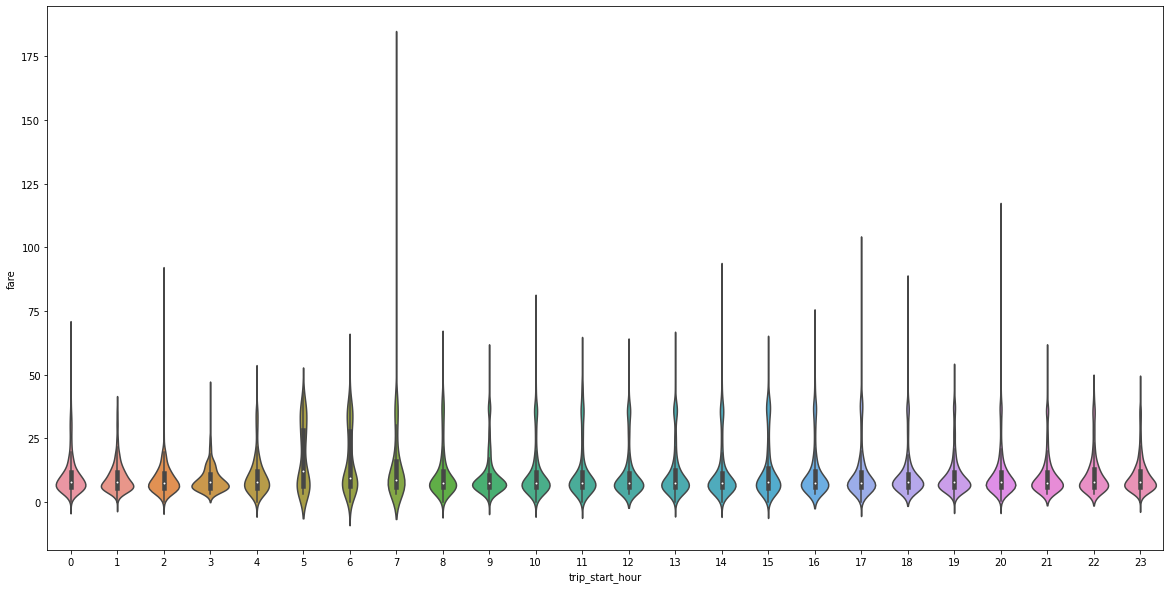

In [19]:
plt.figure(figsize=(20, 10))
sns.violinplot(x=traindf['trip_start_hour'].astype(int), y=traindf['fare'])

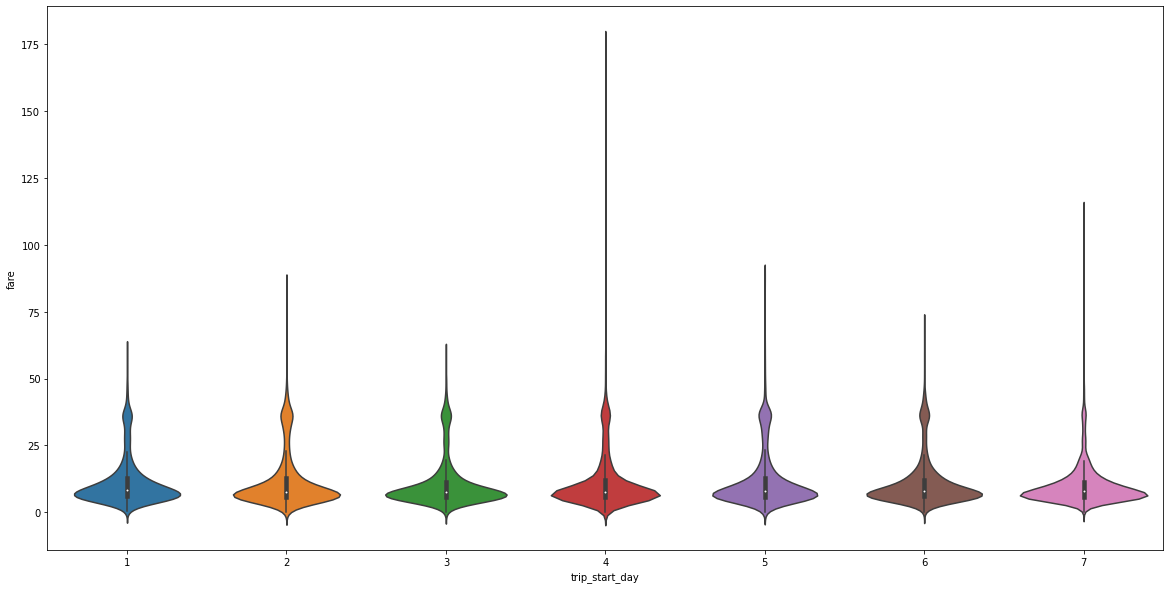

In [20]:
plt.figure(figsize=(20, 10))
sns.violinplot(x=traindf['trip_start_day'].astype(int), y=traindf['fare'])

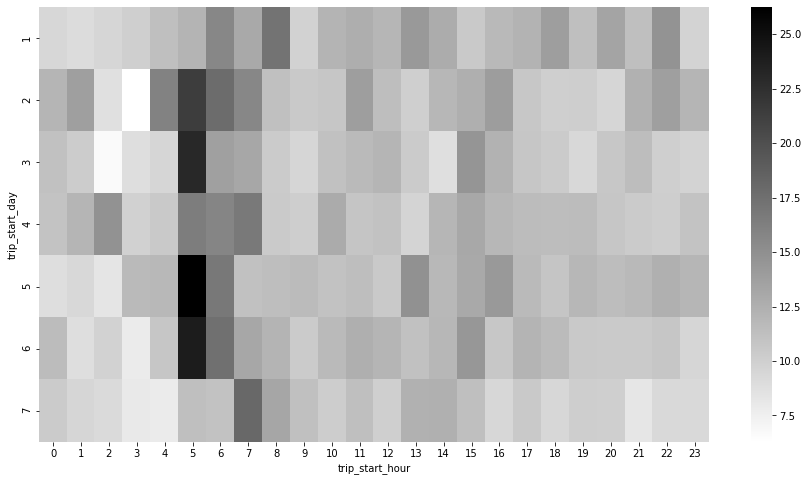

In [21]:
##Average trip fare( day & hour combined )
plt.figure(figsize=(15, 8))
cross = pd.crosstab(traindf['trip_start_day'] , pd.to_numeric(traindf['trip_start_hour']) , traindf['fare'], aggfunc=np.average)
sns.heatmap(cross, annot=False, fmt='g', cmap='binary')

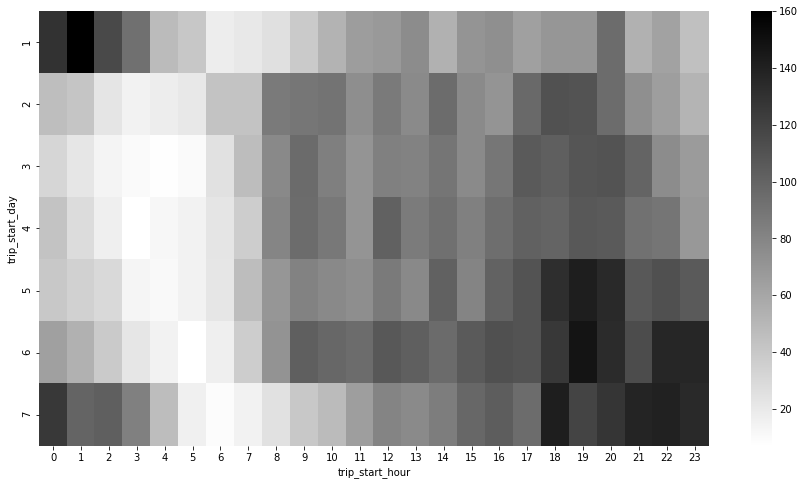

In [22]:
##Number of trips( day-hour wise )
plt.figure(figsize=(15, 8))
cross = pd.crosstab(traindf['trip_start_day'] , pd.to_numeric(traindf['trip_start_hour']) , traindf.index , aggfunc='count')
sns.heatmap(cross, annot=False, fmt='g', cmap='binary')

In [23]:
##Calculate Euclidean distance
from scipy.spatial import distance
def euclidean(row):
  # print(row)
  a = (row['pickup_latitude'], row['pickup_longitude'])
  b = (row['dropoff_latitude'], row['dropoff_longitude'])
  row['distance'] = distance.euclidean(a, b) * 100
  return row

traindf = traindf.apply(euclidean, axis=1)
traindf.head()  

,fare,trip_start_month,trip_start_hour,trip_start_day,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,distance
28,12.25,10.0,1.0,1.0,41.952823,-87.653244,41.920452,-87.679955,4.196872
29,3.85,3.0,15.0,6.0,41.899670,-87.669838,41.920452,-87.679955,2.311313
30,6.05,8.0,23.0,5.0,41.906026,-87.675312,41.920452,-87.679955,1.515438
31,7.25,10.0,21.0,7.0,41.906651,-87.665338,41.920452,-87.679955,2.010275
32,7.85,11.0,11.0,2.0,41.871016,-87.631407,41.849247,-87.624135,2.295137


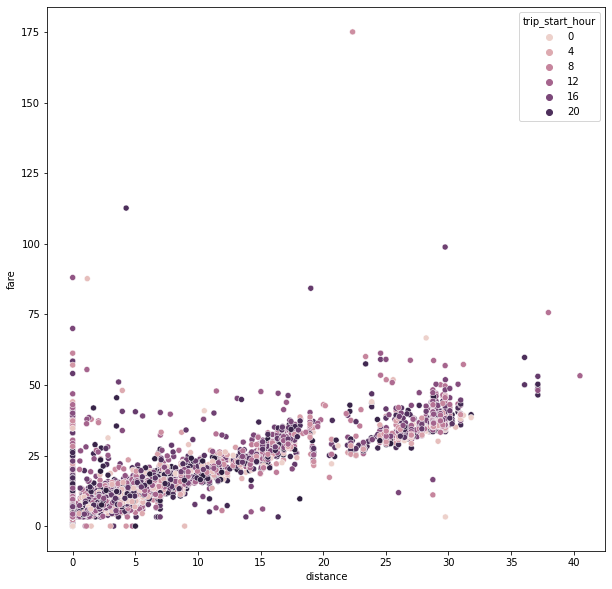

In [24]:
##Fair Vs distance plot( Colored by Trip Start Hour )
plt.figure(figsize=(10, 10))
sns.scatterplot(x=traindf['distance'], y=traindf['fare'], hue=traindf['trip_start_hour'].astype(int))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


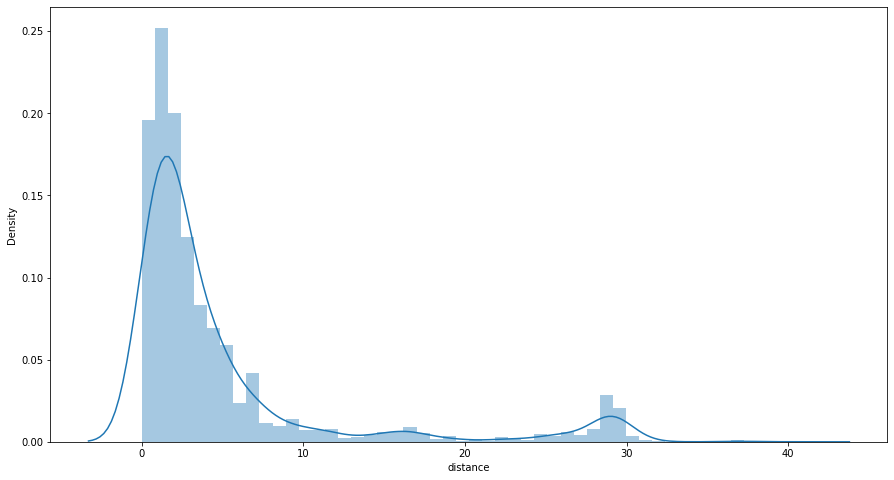

In [25]:
plt.figure(figsize=(15, 8))
sns.distplot(traindf['distance'])

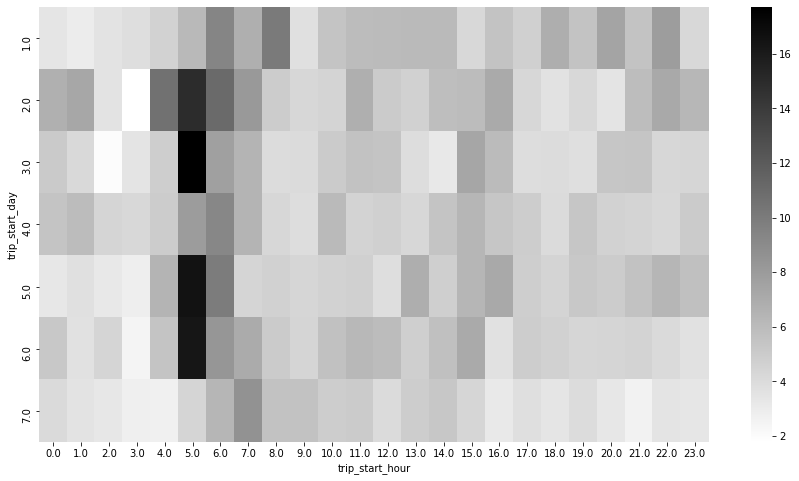

In [26]:
##Average trip distance( day-hour wise )
plt.figure(figsize=(15, 8))
cross = pd.crosstab(traindf['trip_start_day'] , pd.to_numeric(traindf['trip_start_hour']) , traindf['distance'], aggfunc=np.average)
sns.heatmap(cross, annot=False, fmt='g', cmap='binary')

In [27]:
##Train test split ( Original DF )
np.random.seed(seed=2)
msk = np.random.rand(len(df)) < 0.85
traindf = df[msk]
evaldf = df[~msk]

print(len(traindf))
print(len(evaldf))

traindf.to_csv("train.csv", index=False, header=False)
evaldf.to_csv("eval.csv", index=False, header=False)
traindf.head()

12746
2255


,fare,trip_start_month,trip_start_hour,trip_start_day,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,12.45,5,19,6,NaN,NaN,NaN,NaN
1,0.00,3,19,5,NaN,NaN,NaN,NaN
2,27.05,10,2,3,41.836150,-87.648788,NaN,NaN
3,5.85,10,1,2,41.985015,-87.804532,NaN,NaN
4,16.65,5,7,5,41.968069,-87.721559,NaN,NaN


In [33]:
###############################
##Feature engineering functions
def feature_engg_features(features):
  #Add new features
  features['distance'] = ((features['pickup_latitude'] - features['dropoff_latitude'])**2 +  (features['pickup_longitude'] - features['dropoff_longitude'])**2)**0.5

  return(features)

#To be called from TF
def feature_engg(features, label):
  #Add new features
  features = feature_engg_features(features)

  return(features, label)  

In [30]:
###############################
###Data Input pipeline function

# Determine CSV, label, and key columns
#Columns in training sheet -> Can have extra columns too
CSV_COLUMNS = traindf.columns
LABEL_COLUMN = 'fare'

# Set default values for each CSV column( Including Y column )
DEFAULTS = [[0.0], ['1'], ['1'],['1'],[0.0],[0.0],[0.0],[0.0]]

def make_input_fn(filename, mode, vnum_epochs = None, batch_size = 512):
    def _input_fn(v_test=False):     
        # Create list of files that match pattern
        file_list = tf.io.gfile.glob(filename)

        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = vnum_epochs # indefinitely
        else:
            num_epochs = 1 # end-of-input after this        
        
        # Create dataset from file list
        dataset = tf.compat.v1.data.experimental.make_csv_dataset(file_list,
                                                   batch_size=batch_size,
                                                   column_names=CSV_COLUMNS,
                                                   column_defaults=DEFAULTS,
                                                   label_name=LABEL_COLUMN,
                                                   num_epochs = num_epochs,
                                                   num_parallel_reads=30)
        
        dataset = dataset.prefetch(buffer_size = batch_size)

        #Feature engineering
        dataset = dataset.map(feature_engg)

        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = vnum_epochs # indefinitely
            dataset = dataset.shuffle(buffer_size = batch_size)
        else:
            num_epochs = 1 # end-of-input after this

        dataset = dataset.repeat(num_epochs)       
        
        #Begins - Uncomment for testing only -----------------------------------------------------<
        if v_test == True:
          print(next(dataset.__iter__()))
          
        #End - Uncomment for testing only -----------------------------------------------------<
        return dataset
    return _input_fn

In [34]:
#Test dataset read + Feat Engg function's - output's CSV + Feature engg columns
eval_file = "train*.csv"
fn_d = make_input_fn(filename = eval_file,
                    mode = tf.estimator.ModeKeys.EVAL,
                    # vnum_epochs = 1,
                    batch_size = 10)

fn_d(v_test=True)

(OrderedDict([('trip_start_month', <tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'9', b'1', b'3', b'6', b'12', b'12', b'4', b'8', b'11', b'6'],
      dtype=object)>), ('trip_start_hour', <tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'6', b'15', b'16', b'16', b'0', b'1', b'1', b'6', b'17', b'8'],
      dtype=object)>), ('trip_start_day', <tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'3', b'4', b'3', b'7', b'7', b'2', b'7', b'2', b'2', b'4'],
      dtype=object)>), ('pickup_latitude', <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([41.90752 , 41.880993, 41.893215, 41.8996  , 42.004517, 41.8996  ,
       41.947792, 41.878864, 41.79259 , 41.884987], dtype=float32)>), ('pickup_longitude', <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-87.626656, -87.632744, -87.63785 , -87.63331 , -87.66333 ,
       -87.63331 , -87.68384 , -87.62519 , -87.769615, -87.620995],
      dtype=float32)>), ('dropoff_latitude', <tf.Tensor: shape=(10,), dtype=float32, numpy=
arr

<DatasetV1Adapter shapes: (OrderedDict([(trip_start_month, (None,)), (trip_start_hour, (None,)), (trip_start_day, (None,)), (pickup_latitude, (None,)), (pickup_longitude, (None,)), (dropoff_latitude, (None,)), (dropoff_longitude, (None,)), (distance, (None,))]), (None,)), types: (OrderedDict([(trip_start_month, tf.string), (trip_start_hour, tf.string), (trip_start_day, tf.string), (pickup_latitude, tf.float32), (pickup_longitude, tf.float32), (dropoff_latitude, tf.float32), (dropoff_longitude, tf.float32), (distance, tf.float32)]), tf.float32)>

In [35]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12746 entries, 0 to 15001
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare               12746 non-null  float64
 1   trip_start_month   12746 non-null  object 
 2   trip_start_hour    12746 non-null  object 
 3   trip_start_day     12746 non-null  object 
 4   pickup_latitude    12744 non-null  float64
 5   pickup_longitude   12744 non-null  float64
 6   dropoff_latitude   12331 non-null  float64
 7   dropoff_longitude  12331 non-null  float64
dtypes: float64(5), object(3)
memory usage: 896.2+ KB


In [36]:
# Define feature columns(Including feature engineered ones )
def create_feature_cols():
    #Keras format features
    k_month = tf.keras.Input(name='trip_start_month', shape=(1,), dtype=tf.string)
    k_hour  = tf.keras.Input(name='trip_start_hour', shape=(1,), dtype=tf.string)
    k_day  = tf.keras.Input(name='trip_start_day', shape=(1,), dtype=tf.string)
    k_picklat  = tf.keras.Input(name='pickup_latitude', shape=(1,), dtype=tf.float32)
    k_picklon  = tf.keras.Input(name='pickup_longitude', shape=(1,), dtype=tf.float32)
    k_droplat  = tf.keras.Input(name='dropoff_latitude', shape=(1,), dtype=tf.float32)
    k_droplon  = tf.keras.Input(name='dropoff_longitude', shape=(1,), dtype=tf.float32)
    k_distance  = tf.keras.Input(name='distance', shape=(1,), dtype=tf.float32)
    keras_dict_input = {'trip_start_month': k_month, 'trip_start_hour': k_hour, 'trip_start_day' : k_day,
                        'pickup_latitude': k_picklat, 'pickup_longitude': k_picklon,
                        'dropoff_latitude': k_droplat, 'dropoff_longitude': k_droplon, 'distance' : k_distance
                        }

    return({'K' : keras_dict_input})

create_feature_cols()

{'K': {'distance': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'distance')>,
  'dropoff_latitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dropoff_latitude')>,
  'dropoff_longitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dropoff_longitude')>,
  'pickup_latitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'pickup_latitude')>,
  'pickup_longitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'pickup_longitude')>,
  'trip_start_day': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'trip_start_day')>,
  'trip_start_hour': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'trip_start_hour')>,
  'trip_start_month': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'trip_start_month')>}}

In [38]:
#Create model
params_default = {
    'lr' : 0.001,
    'beta_1' : 0.99,
    'beta_2' : 0.999,
    'epsilon' : 1e-08,
    'decay' : 0.01,
    'hidden_layers' : 1
}

##Feature Engineering
# def featengg_funcs(inp):
#     #Add all calculations, pass out as concatenate
#     vpatd_squared = inp[1] * inp[1]
#     vpatd_neg = -1 * inp[1]

#     return keras.layers.concatenate([vpatd_squared, vpatd_neg], axis = 1)

def create_keras_model(params, feature_cols):
    METRICS = [
            keras.metrics.RootMeanSquaredError(name='rmse')
    ]

    #Input layers
    input_feats = []
    for inp in feature_cols['K'].keys():
      input_feats.append(feature_cols['K'][inp])

    ##Input processing
    ##https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
    ##https://github.com/tensorflow/community/blob/master/rfcs/20191212-keras-categorical-inputs.md

    ##Handle categorical attributes( One-hot encoding )
    cat_day = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7'], mask_token=None)(feature_cols['K']['trip_start_day'])
    cat_day = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=7)(cat_day)

    cat_hour = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7','8'
                                                                                      '9','10','11','12','13','14','15','16',
                                                                                      '17','18','19','20','21','22','23','0'
                                                                                      ], mask_token=None)(feature_cols['K']['trip_start_hour'])
    cat_hour = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=24)(cat_hour)

    cat_month = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7','8'
                                                                                      '9','10','11','12'], mask_token=None)(feature_cols['K']['trip_start_month'])
    cat_month = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=12)(cat_month)

    # cat_company = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=df['company'].unique(), mask_token=None)(feature_cols['K']['company'])
    # cat_company = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=len(df['company'].unique()))(cat_company)

    ##Binning
    bins_pickup_lat = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lat)(feature_cols['K']['pickup_latitude'])
    cat_pickup_lat = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lat)+1)(bins_pickup_lat)

    bins_pickup_lon = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lon)(feature_cols['K']['pickup_longitude'])
    cat_pickup_lon = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lon)+1)(bins_pickup_lon)

    bins_drop_lat = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lat)(feature_cols['K']['dropoff_latitude'])
    cat_drop_lat = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lat)+1)(bins_drop_lat)

    bins_drop_lon = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lon)(feature_cols['K']['dropoff_longitude'])
    cat_drop_lon = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lon)+1)(bins_drop_lon)

    ##Categorical cross
    cross_day_hour = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_day, cat_hour])
    hash_cross_day_hour = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=24 * 7)(cross_day_hour)
    cat_cross_day_hour = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens = 24* 7)(hash_cross_day_hour)

    cross_pick_lon_lat = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_pickup_lat, cat_pickup_lon])
    hash_cross_pick_lon_lat = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=(len(bins_lat) + 1) ** 2)(cross_pick_lon_lat)

    cross_drop_lon_lat = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_drop_lat, cat_drop_lon])
    hash_cross_drop_lon_lat = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=(len(bins_lat) + 1) ** 2)(cross_drop_lon_lat)

    # Cross to embedding
    embed_cross_pick_lon_lat = tf.keras.layers.Embedding(((len(bins_lat) + 1) ** 2), 4)(hash_cross_pick_lon_lat)
    embed_cross_pick_lon_lat = tf.reduce_sum(embed_cross_pick_lon_lat, axis=-2)

    embed_cross_drop_lon_lat = tf.keras.layers.Embedding(((len(bins_lat) + 1) ** 2), 4)(hash_cross_drop_lon_lat)
    embed_cross_drop_lon_lat = tf.reduce_sum(embed_cross_drop_lon_lat, axis=-2)

    #Add feature engineered columns - LAMBDA layer

    ###Create MODEL
    ####Concatenate all features( Numerical input )
    x_input_numeric = tf.keras.layers.concatenate([
                    feature_cols['K']['pickup_latitude'], feature_cols['K']['pickup_longitude'],
                    feature_cols['K']['dropoff_latitude'], feature_cols['K']['dropoff_longitude'],
                    feature_cols['K']['distance'] #embed_cross_pick_lon_lat, embed_cross_drop_lon_lat
                    ])

    #DEEP - This Dense layer connects to input layer - Numeric Data
    x_numeric = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform")(x_input_numeric)
    x_numeric = tf.keras.layers.BatchNormalization()(x_numeric)

    ####Concatenate all Categorical features( Categorical converted )
    x_input_categ = tf.keras.layers.concatenate([
                    cat_month, cat_cross_day_hour, cat_pickup_lat, cat_pickup_lon,
                    cat_drop_lat, cat_drop_lon
                    ])
    
    #WIDE - This Dense layer connects to input layer - Categorical Data
    x_categ = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform")(x_input_categ)

    ####Concatenate both Wide and Deep layers
    x = tf.keras.layers.concatenate([x_categ, x_numeric])

    for l_ in range(params['hidden_layers']):
        x = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform",
                                  activity_regularizer=tf.keras.regularizers.l2(0.0001))(x)
        x = tf.keras.layers.BatchNormalization()(x)

    #Final Layer
    out = tf.keras.layers.Dense(1, activation='relu')(x)
    model = tf.keras.Model(input_feats, out)

    #Set optimizer
    opt = tf.keras.optimizers.Adam(lr= params['lr'], beta_1=params['beta_1'], 
                                        beta_2=params['beta_2'], epsilon=params['epsilon'])

    #Compile model
    model.compile(loss='mean_squared_error',  optimizer=opt, metrics = METRICS)

    #Print Summary
    print(model.summary())
    return model

In [39]:
def keras_train_and_evaluate(model, train_dataset, validation_dataset, epochs=100):
  #Add callbacks
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                patience=5, min_lr=0.00001, verbose = 1)
  
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

  #Train and Evaluate
  out = model.fit(train_dataset, 
                  validation_data = validation_dataset,
                  epochs=epochs,
                  # validation_steps = 3,   ###Keep this none for running evaluation on full EVAL data every epoch
                  steps_per_epoch = 100,   ###Has to be passed - Cant help it :) [ Number of batches per epoch ]
                  callbacks=[reduce_lr, #modelsave_callback, #tensorboard_callback, 
                             keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, verbose=True)]
                  )

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
trip_start_day (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
trip_start_hour (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
string_lookup (StringLookup)    (None, 1)            0           trip_start_day[0][0]             
__________________________________________________________________________________________________
string_lookup_1 (StringLookup)  (None, 1)            0           trip_start_hour[0][0]            
______________________________________________________________________________________________

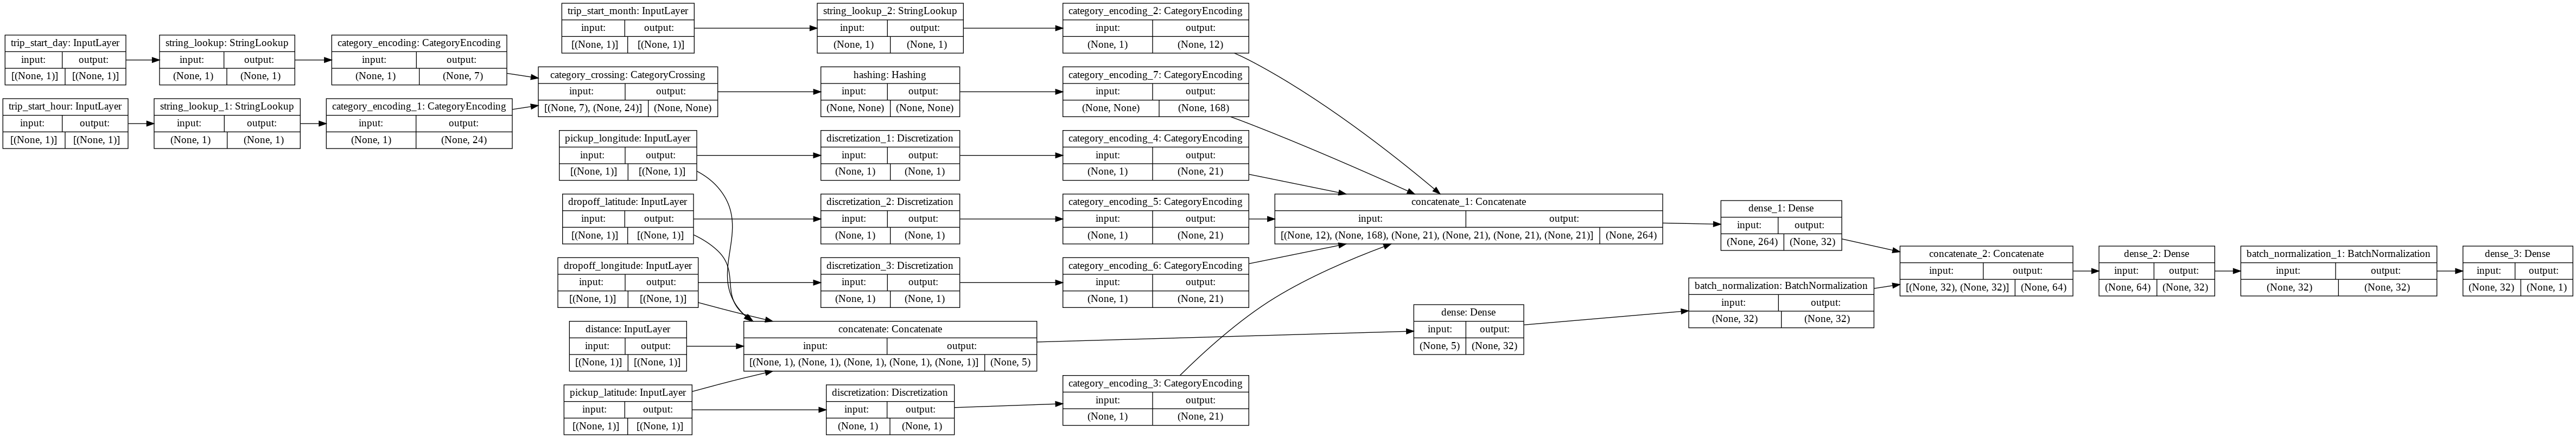

In [40]:
#Create dataset input functions
train_dataset = make_input_fn(filename = 'train*.csv',
                    mode = tf.estimator.ModeKeys.TRAIN,
                    # vnum_epochs = epochs,
                    batch_size = 128)()

validation_dataset = make_input_fn(filename = 'eval*.csv',
                    mode = tf.estimator.ModeKeys.EVAL,
                    # vnum_epochs = 1,
                    batch_size = 512)()

m_ = create_keras_model(params = params_default, feature_cols = create_feature_cols())
tf.keras.utils.plot_model(m_, show_shapes=True, rankdir="LR")

In [41]:
# !rm -rf "./logs"
# %tensorboard --logdir "./logs"

keras_train_and_evaluate(m_, train_dataset, validation_dataset, 50)

Epoch 1/50
100/100 [==============================] - 7s 46ms/step - loss: 203.3831 - rmse: 14.2572 - val_loss: 180.4634 - val_rmse: 13.4298
Epoch 2/50
100/100 [==============================] - 4s 36ms/step - loss: 139.7395 - rmse: 11.8155 - val_loss: 1764.4128 - val_rmse: 42.0043
Epoch 3/50
100/100 [==============================] - 4s 36ms/step - loss: 86.7925 - rmse: 9.3103 - val_loss: 2961.3621 - val_rmse: 54.4181
Epoch 4/50
100/100 [==============================] - 4s 36ms/step - loss: 59.5893 - rmse: 7.7179 - val_loss: 182.2938 - val_rmse: 13.5013
Epoch 5/50
100/100 [==============================] - 4s 36ms/step - loss: 49.7754 - rmse: 7.0491 - val_loss: 214.5759 - val_rmse: 14.6481
Epoch 6/50
100/100 [==============================] - 4s 36ms/step - loss: 37.2637 - rmse: 6.0958 - val_loss: 228.5126 - val_rmse: 15.1162

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 7/50
100/100 [==============================] - 4s 36ms/step - loss: 32.

In [42]:
# ##Prediction on model
# ## BUT HERE ALL FEATURES HAVE TO BE PASSED, EVEN THE Calculated ones
data = tf.data.Dataset.from_tensor_slices({'dropoff_latitude': [[41.920452]],
                         'dropoff_longitude': [[-87.679955]],
                         'pickup_latitude': [[41.952823]],
                         'pickup_longitude': [[-87.653244]],
                         'trip_start_day': [["1"]],
                         'trip_start_hour': [["5"]],
                         'trip_start_month': [["6"]],
                         'distance':[[0.04196861]]})

m_.predict(data)

array([[6.9782453]], dtype=float32)

In [43]:
@tf.function
def serving(dropoff_latitude, dropoff_longitude, pickup_latitude, pickup_longitude, trip_start_day, trip_start_hour, trip_start_month):
    ##Feature engineering( calculate distance )
    distance = tf.cast( tf.sqrt((tf.abs(dropoff_latitude - pickup_latitude))**2 + (tf.abs(dropoff_longitude - pickup_longitude))**2), tf.float32)

    payload = {
        'dropoff_latitude': dropoff_latitude,
        'dropoff_longitude': dropoff_longitude,
        'pickup_latitude': pickup_latitude,
        'pickup_longitude': pickup_longitude,
        'trip_start_day': trip_start_day,
        'trip_start_hour': trip_start_hour,
        'trip_start_month': trip_start_month,
        'distance': distance
    }
    
    ## Predict
    ##IF THERE IS AN ERROR IN NUMBER OF PARAMS PASSED HERE OR DATA TYPE THEN IT GIVES ERROR, "COULDN'T COMPUTE OUTPUT TENSOR"
    predictions = m_(payload)
    return predictions

serving = serving.get_concrete_function(trip_start_day=tf.TensorSpec([None,], dtype= tf.string, name='trip_start_day'), 
                                        trip_start_hour=tf.TensorSpec([None,], dtype= tf.string, name='trip_start_hour'),
                                        trip_start_month=tf.TensorSpec([None], dtype= tf.string, name='trip_start_month'), 
                                        dropoff_latitude=tf.TensorSpec([None,], dtype= tf.float32, name='dropoff_latitude'),
                                        dropoff_longitude=tf.TensorSpec([None,], dtype= tf.float32, name='dropoff_longitude'), 
                                        pickup_latitude=tf.TensorSpec([None,], dtype= tf.float32, name='pickup_latitude'),
                                        pickup_longitude=tf.TensorSpec([None,], dtype= tf.float32, name='pickup_longitude')
                                        )

version = "1"  #{'serving_default': call_output}
tf.saved_model.save(
    m_,
    "./exported_model/" + version,
    signatures=serving
) 

# tf.saved_model.save(
#     m_,
#     "./exported_model/" + version,
#     signatures={'serving_default': serving}
# ) 

INFO:tensorflow:Assets written to: ./exported_model/1/assets


In [44]:
# !zip -r /content/model.zip /content/exported_model/1
!tar -cvf /content/model.tar /content/exported_model/1/

tar: Removing leading `/' from member names
/content/exported_model/1/
/content/exported_model/1/assets/
/content/exported_model/1/saved_model.pb
/content/exported_model/1/variables/
/content/exported_model/1/variables/variables.data-00000-of-00001
/content/exported_model/1/variables/variables.index


In [45]:
##Check signature
!saved_model_cli show --dir "./exported_model/1" --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['dropoff_latitude'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: serving_default_dropoff_latitude:0
    inputs['dropoff_longitude'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: serving_default_dropoff_longitude:0
    inputs['pickup_latitude'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: serving_default_pickup_latitude:0
    inputs['pickup_longitude'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
 

In [46]:
#LOCAL: Predict using Keras prediction function
saved_mod = tf.saved_model.load("./exported_model/" + version)

#Get prediction function from serving
f = saved_mod.signatures['serving_default']

#Run prediction function from serving
f(dropoff_latitude=tf.convert_to_tensor([41.920452]), dropoff_longitude = tf.convert_to_tensor([-87.679955]), pickup_latitude = tf.convert_to_tensor([41.952823]), 
  pickup_longitude =tf.convert_to_tensor([-87.653244]), trip_start_day=tf.convert_to_tensor(["1"]), trip_start_hour=tf.convert_to_tensor(["5"]),
  trip_start_month=tf.convert_to_tensor(["6"]))

{'output_0': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[6.9782453]], dtype=float32)>}

In [47]:
###Install TF Model server

# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!apt-get remove tensorflow-model-server
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package tensorflow-model-server
deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  16533      0 --:--:-- --:--:-- --:--:-- 16441
OK
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:6 http://ppa.launchpad.net/c

In [48]:
###Start Tensorflow server
# %%bash --bg 
# export TF_CPP_MIN_VLOG_LEVEL=0

%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8505 \
  --model_name=model \
  --model_base_path="/content/exported_model" >server.log 2>&1

Starting job # 0 in a separate thread.


In [49]:
!tail server.log

2021-01-03 05:42:37.678478: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:206] Restoring SavedModel bundle.
2021-01-03 05:42:37.689055: I external/org_tensorflow/tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299995000 Hz
2021-01-03 05:42:37.777846: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:190] Running initialization op on SavedModel bundle at path: /content/exported_model/1
2021-01-03 05:42:37.843580: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:277] SavedModel load for tags { serve }; Status: success: OK. Took 279006 microseconds.
2021-01-03 05:42:37.853829: I tensorflow_serving/servables/tensorflow/saved_model_warmup_util.cc:59] No warmup data file found at /content/exported_model/1/assets.extra/tf_serving_warmup_requests
2021-01-03 05:42:37.854009: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: model version: 1}
2021-01-03 05:42:37.856744: I tensorflow_servin

In [50]:
import json
import requests

#Create payload
data_py = {"instances":[{'dropoff_latitude': [41.920452],
                         'dropoff_longitude': [-87.679955],
                         'pickup_latitude': [41.952823],
                         'pickup_longitude': [-87.653244],
                         'trip_start_day': ["1"],
                         'trip_start_hour': ["5"],
                         'trip_start_month': ["6"]}]}

data = json.dumps(data_py)
print("payload: ", data)

#Run request on TMS
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8505/v1/models/model:predict', data=data, headers=headers)
json_response.text

payload:  {"instances": [{"dropoff_latitude": [41.920452], "dropoff_longitude": [-87.679955], "pickup_latitude": [41.952823], "pickup_longitude": [-87.653244], "trip_start_day": ["1"], "trip_start_hour": ["5"], "trip_start_month": ["6"]}]}


'{\n    "error": "In[0] should be a scalar: [1]\\n\\t [[{{node model/category_encoding/Assert/Assert}}]]"\n}'